In [1]:
# import packages
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# check keras version
keras.__version__

'2.3.1'

In [4]:
df = pd.read_pickle(r'C:\Users\ran\Google Drive\towards data science\data.pkl')

# data

In [5]:
# print the head of the dataframe
df.head()

,y,X1,X2,X3
0,0.198382,15,1.84227,6.5
1,0.195289,16,1.88341,13.5
2,0.195089,16,1.92455,20.5
3,0.201794,16,1.96569,27.5
4,0.208498,16,2.00683,34.5


In [6]:
# define y variable, i.e., what we want to predict
y_col='y'

In [7]:
#print the shape of the data
df.shape

(32128, 4)

plot data

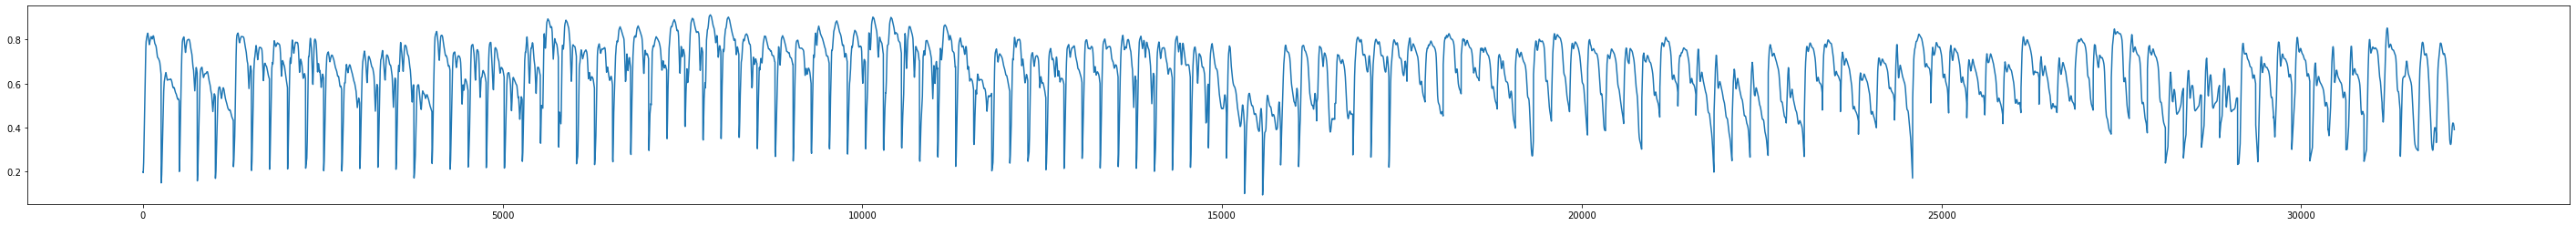

In [8]:
plt.figure(figsize=(50,4))
plt.plot(range(len(df)),df[y_col]);

# split the data to train and test

In [9]:
test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy() # the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()
train.shape, test.shape

((28916, 4), (3212, 4))

# plot train and test

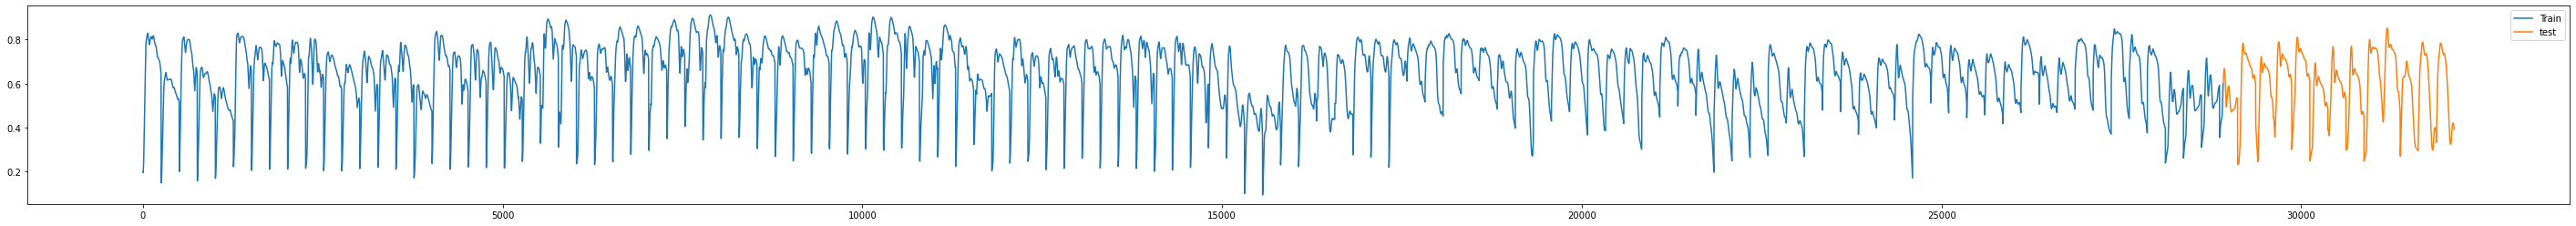

In [10]:
plt.figure(figsize=(50,4))
plt.plot(train.index,train[y_col],label='Train');
plt.plot(test.index,test[y_col],label='test')
plt.legend();

# Seperate X and y

In [26]:
#seperate X and y only for the train data (for now)
X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)

(28916, 3) (28916, 1)


In [12]:
X_train.head()

,X1,X2,X3
0,15,1.84227,6.5
1,16,1.88341,13.5
2,16,1.92455,20.5
3,16,1.96569,27.5
4,16,2.00683,34.5


In [13]:
y_train.head()

,y
0,0.198382
1,0.195289
2,0.195089
3,0.201794
4,0.208498


# scale X train and y train

In [14]:
# scale X and y train using sklearn MinMaxScaler model
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)

# this is beutifully explain in mastery
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(28916, 3)
(28916, 1)
(28916,)


# instantiate the model

In [15]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

In [16]:
# check that the generator is ok, its shape should be (batch_size,n_input,n_features)
generator[0][0].shape

(32, 25, 3)

In [17]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               92400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 92,551
Trainable params: 92,551
Non-trainable params: 0
_________________________________________________________________


# fit the model

In [18]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
903/903 [==============================] - 14s 15ms/step - loss: 0.0311
Epoch 2/5
903/903 [==============================] - 14s 15ms/step - loss: 0.0189
Epoch 3/5
903/903 [==============================] - 14s 16ms/step - loss: 0.0170
Epoch 4/5
903/903 [==============================] - 15s 16ms/step - loss: 0.0161
Epoch 5/5
903/903 [==============================] - 15s 16ms/step - loss: 0.0152


# plot losses

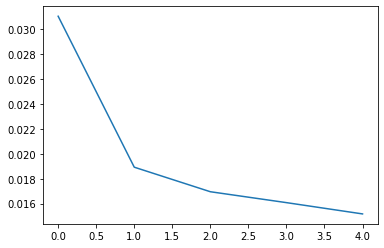

In [19]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

# make predictions

In [20]:
X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

In [21]:
test_generator[0][0].shape

(32, 25, 3)

In [22]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [23]:
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})

In [24]:
results

,y_true,y_pred
0,0.632569,0.644635
1,0.623912,0.647779
2,0.615255,0.651004
3,0.606598,0.654239
4,0.597941,0.656492
...,...,...
3182,0.404971,0.442737
3183,0.403237,0.441596
3184,0.398993,0.439773
3185,0.394749,0.438899


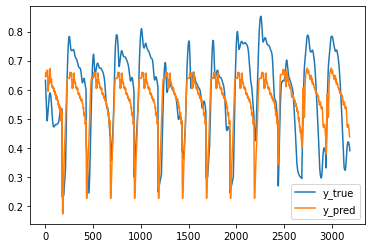

In [25]:
results.plot();